# Dice Detection Project
Dice detection project for Computer Vision (include description)

## 1. Import Dependencies

In [1]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

import kagglehub
from ultralytics import YOLO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Project constants

In [2]:
path = kagglehub.dataset_download("nellbyler/d6-dice")
print("Path to dataset files:", path)

# ANNOTATION_PATH = path + "/d6-dice/Annotations"
# IMAGE_PATH = path + "/d6-dice/Images"

ANNOTATION_PATH = os.path.join(path, "d6-dice", "Annotations")
IMAGE_PATH = os.path.join(path, "d6-dice", "Images")

# windows delim
split_char = '\\'

# linux delim
#split_char = '/'

Path to dataset files: C:\Users\leeal\.cache\kagglehub\datasets\nellbyler\d6-dice\versions\3


## 2. Split data into train/test/validation

In [3]:
anotation_files = []
for dir,_,files in os.walk(ANNOTATION_PATH):
    for filename in files:
        if filename[-4:] == '.txt':
            anotation_files += [(os.path.join(dir,filename))]

# remove classes.txt file from image pool
anotation_files.pop(0)

# 70/15/15 train-test split
train_ratio = .7
test_ratio = (1.0 - train_ratio) / 2
valid_ratio = test_ratio

SIZE = len(anotation_files)
N = list(range(SIZE))
# random.suffle(N)

train_size = int(SIZE * train_ratio)
test_size = int(SIZE * test_ratio)
valid_size = int(SIZE * valid_ratio)

# get indexes of split list
#train_i = N[:train_size]
#valid_i = N[train_size:(train_size + valid_size)]
#test_i = N[train_size+valid_size:]

# Add any files that might have been accidentally skipped to the train set
while((train_size + test_size + valid_size) < len(anotation_files)):
    train_size += 1

print(train_size)
print(test_size)
print(valid_size)
print(len(anotation_files))

176
37
37
250


## 3. Organize and prep data for YOLO

In [ ]:
# Create directories if they don't exist
os.makedirs('datasets/train/images', exist_ok=True)
os.makedirs('datasets/train/labels', exist_ok=True)

os.makedirs('datasets/test/images', exist_ok=True)
os.makedirs('datasets/test/labels', exist_ok=True)

os.makedirs('datasets/valid/images', exist_ok=True)
os.makedirs('datasets/valid/labels', exist_ok=True)

# helper to organize files into their respective directories
def copy_files(i, dir, ano_files):
    # get the image filename
    ano_file = ano_files[i]
    img_file = ano_file.split(split_char)[-1][0:-4] + '.jpg'

    # copy into folders
    shutil.copy(ano_file, dir + '/labels')
    shutil.copy(os.path.join(IMAGE_PATH, img_file), os.path.join(dir + '/images/', img_file))

# copy image and label files into local directories
for i in range(train_size):
    copy_files(i, './datasets/train', anotation_files)

test_start = train_size + valid_size
test_end = test_start + test_size
for i in range(test_start, test_end):
    copy_files(i, './datasets/test', anotation_files)


valid_start = train_size
valid_end = valid_start + valid_size
for i in range(valid_start, valid_end):
    copy_files(i, './datasets/valid', anotation_files)

In [ ]:
import yaml

source_path = current_directory = os.getcwd()

train_path = os.path.join(source_path, "datasets", "train")
test_path = os.path.join(source_path, "datasets", "test")
valid_path = os.path.join(source_path, "datasets", "valid")

data_yaml = dict(
    train = train_path,
    test = test_path,
    val = valid_path,
    
    nc = 6,
    names = list('123456'),

    device = 'cpu'
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\datasets\train


In [ ]:
# labels
names = list(range(1,7))
M = list(range(len(names)))
class_map = dict(zip(M,names))

# load model
model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

## 4. Train Model

In [ ]:
train_results = model.train(
    data = "./data.yaml",
    epochs = 14,
    imgsz = 480
)

## 5. Masking

In [4]:
best_weights_path = os.path.join("runs", "detect", "train19", "weights", "best.pt")
pred_dataset_path = kagglehub.dataset_download("koryakinp/d6-dices-images")

dataset_images = os.path.join(pred_dataset_path, "dataset-images")

print(pred_dataset_path)
print(best_weights_path)

image_dir = os.listdir(os.path.join(pred_dataset_path, 'dataset-images'))
image_list = []
for file in image_dir:
    image_list.append(os.path.join(pred_dataset_path,'dataset-images', file))

print(image_list[0])

C:\Users\leeal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2
runs\detect\train19\weights\best.pt
C:\Users\leeal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2\dataset-images\0001091d-6438-4cc3-bb80-a79534f9ccd8.jpg


In [5]:
masked_images = []

Mask images

In [6]:
os.makedirs('test_images/masked_images', exist_ok=True)

def save_im(image_path, result):
    cv2.imwrite(image_path, result)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i in range(len(image_list)):
        image = cv2.imread(image_list[i])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, dice_mask = cv2.threshold(gray_image, 125, 255, cv2.THRESH_BINARY_INV)
        result = cv2.bitwise_and(image, image, mask=dice_mask)
        result[dice_mask == 0] = [255, 255, 255]
        result[dice_mask != 0] = [0, 0, 0]

        #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        #plt.axis("off")
        #plt.title("Masked Dice")
        #plt.show()
        #masked_images.append(result)

        image_name = 'masked_image'+str(i)+'.jpg'

        im_name = os.path.join('test_images', 'masked_images', image_name)
        masked_images.append(im_name)

        # output to file
        #futures.append(executor.submit(save_im, im_name, result))

    # wait to retrieve all futures
    for future in futures:
        future.result()

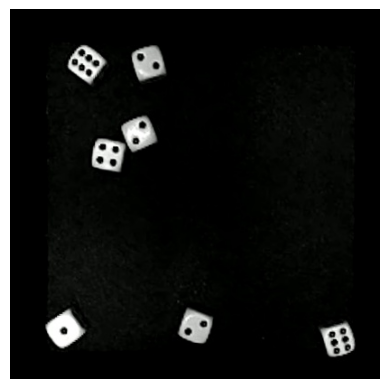

In [7]:
def show_image(image_path):
    # Load the image from the directory
    image = Image.open(image_path)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

show_image(image_list[0])

## 6. Predict Using a Different Dataset

In [337]:
def get_results(results, image_list, file_name):
    keys = [0, 1, 2, 3, 4, 5]
    values = [1, 2, 3, 4, 5, 6]

    image_list = sorted(image_list)

    class_dict = dict(zip(keys, values))

    data = pd.DataFrame(columns= range(6))
    for i in range(len(results)):
        # add the data to a Data Frame
        result = pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
        
        # append the 
        file = image_list[i]
        result['img index'] = int(i)
        result['file'] = file

        data = pd.concat([data, result], axis=0)

    # rename columns
    data.columns = ['x', 'y', 'x2', 'y2', 'cl', 'label', 'i', 'file']

    # apply correct labellings
    data['label'] = data['label'].map(class_dict)
    data['i'] = data['i'].astype(int)
    data = data.reset_index(drop=True)

    # output data
    os.makedirs("results", exist_ok=True)
    data.to_csv(os.path.join("results", file_name + ".csv"), index=False, header=True)

    display(data)
    
    return data

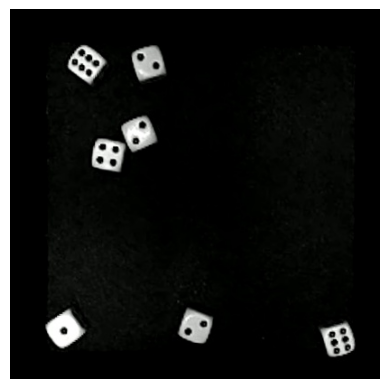

In [179]:
show_image(image_list[0])

Predict bounding bes and values of the dice in another dataset

In [9]:
trained_model = YOLO(best_weights_path)

In [27]:
results = trained_model.predict(source=image_list[:20], conf=0.2)


0: 480x480 2 1s, 3 2s, 1 4, 2 6s, 709.7ms
1: 480x480 1 1, 2 2s, 1 3, 2 4s, 1 5, 1 6, 709.7ms
2: 480x480 1 1, 1 2, 2 3s, 2 4s, 2 5s, 709.7ms
3: 480x480 1 1, 2 3s, 1 4, 3 5s, 2 6s, 709.7ms
4: 480x480 3 1s, 2 2s, 1 4, 1 5, 1 6, 709.7ms
5: 480x480 1 1, 3 2s, 2 5s, 2 6s, 709.7ms
6: 480x480 1 1, 1 2, 1 3, 1 5, 2 6s, 709.7ms
7: 480x480 1 1, 2 3s, 1 4, 3 5s, 709.7ms
8: 480x480 1 2, 1 3, 1 4, 2 6s, 709.7ms
9: 480x480 3 2s, 2 3s, 2 5s, 709.7ms
10: 480x480 1 1, 2 4s, 1 5, 3 6s, 709.7ms
11: 480x480 1 1, 1 2, 2 3s, 2 4s, 1 5, 709.7ms
12: 480x480 3 1s, 3 2s, 1 4, 1 5, 709.7ms
13: 480x480 3 1s, 1 2, 1 3, 2 6s, 709.7ms
14: 480x480 2 1s, 2 3s, 2 4s, 2 5s, 709.7ms
15: 480x480 1 1, 2 2s, 2 3s, 1 4, 1 6, 709.7ms
16: 480x480 1 1, 2 3s, 1 4, 1 5, 709.7ms
17: 480x480 1 2, 2 3s, 3 4s, 1 5, 709.7ms
18: 480x480 2 1s, 2 2s, 1 3, 2 6s, 709.7ms
19: 480x480 2 1s, 5 6s, 709.7ms
Speed: 2.4ms preprocess, 709.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 480)


In [11]:
results_masked = trained_model.predict(source=masked_images[:20], conf=0.2)


0: 480x480 3 1s, 2 2s, 1 4, 2 6s, 1189.0ms
1: 480x480 1 1, 3 2s, 1 3, 2 4s, 1 5, 1 6, 1189.0ms
2: 480x480 1 1, 2 2s, 3 3s, 2 4s, 2 5s, 1 6, 1189.0ms
3: 480x480 1 1, 2 3s, 1 4, 1 5, 2 6s, 1189.0ms
4: 480x480 4 1s, 2 2s, 1 3, 1 4, 1 5, 1 6, 1189.0ms
5: 480x480 3 1s, 2 2s, 1 5, 3 6s, 1189.0ms
6: 480x480 2 1s, 1 2, 1 3, 1 4, 1 5, 2 6s, 1189.0ms
7: 480x480 1 1, 3 3s, 1 4, 1 5, 2 6s, 1189.0ms
8: 480x480 1 1, 1 2, 1 3, 1 4, 2 6s, 1189.0ms
9: 480x480 3 1s, 2 2s, 4 3s, 1 5, 1189.0ms
10: 480x480 1 1, 2 4s, 1 5, 2 6s, 1189.0ms
11: 480x480 2 2s, 2 3s, 1 4, 1 5, 1189.0ms
12: 480x480 4 1s, 3 2s, 1 5, 1189.0ms
13: 480x480 4 1s, 1 2, 1 3, 2 6s, 1189.0ms
14: 480x480 2 1s, 2 3s, 2 4s, 2 5s, 1189.0ms
15: 480x480 3 1s, 2 3s, 2 4s, 1 6, 1189.0ms
16: 480x480 1 1, 2 3s, 1 4, 1 5, 1189.0ms
17: 480x480 1 1, 1 2, 4 3s, 1 4, 1 5, 1 6, 1189.0ms
18: 480x480 4 1s, 1 3, 2 6s, 1189.0ms
19: 480x480 2 1s, 5 6s, 1189.0ms
Speed: 5.2ms preprocess, 1189.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 480)


Generate Data Frames

In [338]:
orig_df = get_results(results, image_list, "orig_20")
masked_df = get_results(results_masked, masked_images, "masked_20")

C:\Users\leeal\AppData\Local\Temp\ipykernel_2604\3727267081.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,85.956535,141.269653,130.124985,186.964828,0.916102,4,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
1,340.447662,344.211578,386.485809,389.874268,0.853071,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
2,60.501671,37.584240,107.788902,86.368271,0.820382,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
3,36.548065,331.706299,85.416512,379.563141,0.786982,1,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
4,182.049759,329.882111,228.512970,376.264862,0.753410,2,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
...,...,...,...,...,...,...,...,...
139,195.161377,254.241119,241.793045,302.875854,0.849534,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
140,147.901520,337.410645,195.639862,384.978638,0.848122,1,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
141,49.383999,76.250816,95.987831,124.704964,0.831824,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
142,41.437641,201.946136,90.939857,251.973175,0.825250,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...


C:\Users\leeal\AppData\Local\Temp\ipykernel_2604\3727267081.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,341.278015,345.780731,386.588379,389.460144,0.863240,6,0,test_images\masked_images\masked_image0.jpg
1,60.296967,37.599270,107.444344,85.423668,0.855326,6,0,test_images\masked_images\masked_image0.jpg
2,86.317871,141.089081,129.242325,185.826248,0.810191,4,0,test_images\masked_images\masked_image0.jpg
3,36.781658,331.356293,85.406960,379.582428,0.785843,1,0,test_images\masked_images\masked_image0.jpg
4,120.439240,116.825806,164.676773,160.845673,0.705994,2,0,test_images\masked_images\masked_image0.jpg
...,...,...,...,...,...,...,...,...
153,49.360149,75.983650,95.653351,122.419006,0.829284,6,19,test_images\masked_images\masked_image10013.jpg
154,148.012527,338.360474,195.030334,384.598511,0.803652,1,19,test_images\masked_images\masked_image10013.jpg
155,225.624039,70.935616,268.048767,112.494324,0.780874,1,19,test_images\masked_images\masked_image10013.jpg
156,51.690773,31.286892,98.851494,78.044189,0.728702,6,19,test_images\masked_images\masked_image10013.jpg


## 7. Remove duplicate bounding boxes

Helper Functions

In [358]:
def find_center(x1, y1, x2, y2):
    Xc = abs((x2 - x1) / 2)
    Yc = abs((y2 - y1) / 2)

    return (Xc, Yc)

def coincides(b1, b2, scale=0.1):
    # obtain relative centers
    # c1 = np.array(find_center(b1[0], b1[1], b1[2], b1[3]))
    # c2 = np.array(find_center(b2[0], b2[1], b2[2], b2[3]))
    
    # threshold = np.linalg.norm(c1) * scale

    # # add offsets
    # c1 = c1 + np.array(b1[0], b1[1])
    # c2 = c2 + np.array(b2[0], b2[1])

    # dist = np.linalg.norm(c2 - c1)

    # bounding box (BB) 1 diagonal length
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b1[2], b1[3]])
    threshold = np.linalg.norm(p1 - p2) * scale

    # distance between BB 1 and BB 2
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b2[0], b2[1]])
    dist = np.linalg.norm(p1 - p2)
    
    return dist < threshold

Removal of Extra Bounding Boxes

In [376]:
# compare bounding boxes
def compare_boxes(data, cl):
    remove_idx = []
    for i in range(len(data)):
        # if data was already removed, then skip
        if i in remove_idx:
            continue
        
        # obtain first bounding box
        b1 = data[i]

        for j in range(len(data)):
            # if data was already removed, then skip
            if j in remove_idx:
                continue

            # obtain second bounding box
            b2 = data[j]

            if np.array_equiv(b1, b2):
                continue
            
            # if 2 bounding boxes coincide, then take the value with the higher confidence level
            if coincides(b1, b2):
                remove_idx.append(j if cl[i] > cl[j] else i)
    
    return remove_idx

# remove any duplicate bounding boxes
def remove_dup_BB(df):
    max_index = df.iloc[-1]['i'] + 1

    offset = 0
    remove_idx = []
    for index in range(max_index):
        # remove the label, confidence level, image index, and image path
        view = df[df['i'] == index].iloc[:, :-4]
        cl = df[df['i'] == index]['cl']
        cl = cl.reset_index(drop=True)

        # remove duplicate bounding boxes
        dup_idx = compare_boxes(view.to_numpy(), cl)
        dup_idx = [i + offset for i in dup_idx]

        remove_idx.extend(dup_idx)

        # increment offset
        offset = offset + len(view)

    print(remove_idx)
    if remove_idx:
        filtered_df = df.drop(remove_idx, axis=1)
    else:
        return df

    return filtered_df

filtered_orig_df = remove_dup_BB(orig_df)

[7, 15, 23, 32, 31, 40, 48, 80, 86, 95, 110]


KeyError: '[7, 15, 23, 32, 31, 40, 48, 80, 86, 95, 110] not found in axis'

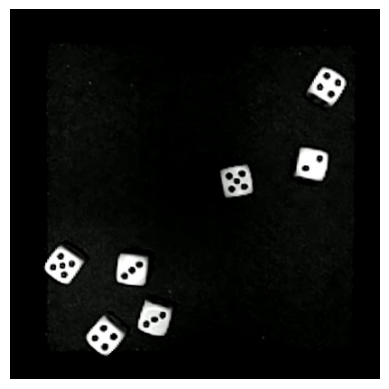

In [118]:
show_image(image_list[2])

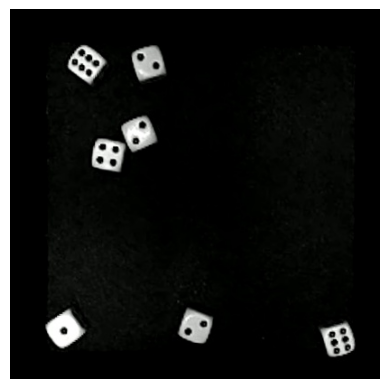

In [184]:
show_image(image_list[0])